In [20]:
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Research import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.stats as ss
import numpy as np
from pykalman import KalmanFilter
import statsmodels.tsa.stattools as sm
import pandas as pd
import math
qb = QuantBook()

s1 = qb.AddEquity("amzn")
s2 = qb.AddEquity("ge")
start_date = datetime(2016,1,1)
end_date = datetime(2018,1,1)
hedge_lookback = 15
dist = 253
entry = 2.0
zstop = 4.5
exit = 0.5

series1 = qb.History(s1.Symbol, start_date, end_date, Resolution.Daily).close.values.tolist()
series2 = qb.History(s2.Symbol, start_date, end_date, Resolution.Daily).close.values.tolist()

In [21]:
def run_kalman(series):
    kf_stock = KalmanFilter(transition_matrices = [1], observation_matrices = [1],
                            initial_state_mean = series[0], 
                            observation_covariance=0.001,
                            transition_covariance=0.0001)
    filtered_series = kf_stock.smooth(series)[0].flatten()
    return filtered_series

def sm_resids(series1, series2):
    X = sm.add_constant(series1)
    model = sm.OLS(series2, X)
    results = model.fit()
    return results.resid[-1]

def get_og_spreads(series1, series2, length):
    spreads = []
    zscores = []
    
    for i in range(1, hedge_lookback):
        start_index = len(series1) - length - hedge_lookback + i
        resid = sm_resids(series2[start_index-hedge_lookback:start_index], 
                                  series1[start_index-hedge_lookback:start_index])
        spreads = np.append(spreads, resid)
    
    for i in range(length):
        start_index = len(series1) - length + i
        resid = sm_resids(series2[start_index-hedge_lookback:start_index], 
                                  series1[start_index-hedge_lookback:start_index])
        spreads = np.append(spreads, resid)
        zscore = ss.zscore(spreads[-hedge_lookback:], nan_policy='omit')[-1]
        zscores = np.append(zscores, zscore)
        
    return spreads, zscores

og_spreads, og_zscores = get_og_spreads(series1,series2,dist)

In [22]:
def get_simple_spreads(series1,series2,length):
    spreads = np.array(series1) - np.array(series2)
    zscores = []
    
    for i in range(length):
        start_index = len(series1) - length + i
        moving_differences = ss.zscore(spreads[start_index-hedge_lookback:start_index], nan_policy='omit')
        zscores = np.append(zscores,moving_differences[-1])
        
    return spreads[-length:], zscores

simple_spreads, simple_zscores = get_simple_spreads(series1,series2, dist)

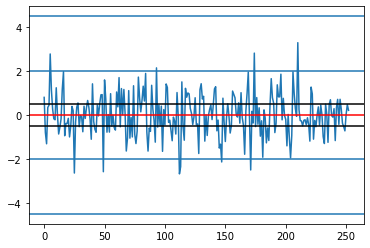

In [23]:
def get_pct_spreads(series1,series2,length):
    series1_df = pd.DataFrame(series1)
    series2_df = pd.DataFrame(series2)
    series1_changes = pd.DataFrame.pct_change(series1_df)
    series2_changes = pd.DataFrame.pct_change(series2_df)
    spreads = np.array(series1_changes) - np.array(series2_changes)
    zscores= []
    
    for i in range(length):
        start_index = len(series1) - length + i
        moving_differences = ss.zscore(spreads[start_index-hedge_lookback:start_index], nan_policy='omit')
        zscores = np.append(zscores,moving_differences[-1])
        
    return spreads[-length:], zscores

pct_spreads, pct_zscores = get_pct_spreads(series1,series2, dist)
plt.plot(pct_zscores)
plt.axhline(y=entry)
plt.axhline(y=-entry)
plt.axhline(y=0, color='r')
plt.axhline(y=zstop)
plt.axhline(y=-zstop)
plt.axhline(y=exit, color='k')
plt.axhline(y=-exit, color='k')

In [24]:
def get_ratio_spreads(series1, series2, length):
    spreads = np.array(series1)/np.array(series2)
    zscores = []
    
    for i in range(length):
        start_index = len(series1) - length + i
        moving_differences = ss.zscore(spreads[start_index-hedge_lookback:start_index], nan_policy='omit')
        zscores = np.append(zscores,moving_differences[-1])
        
    return spreads[-length:], zscores

ratio_spreads, ratio_zscores = get_ratio_spreads(series1,series2, dist)

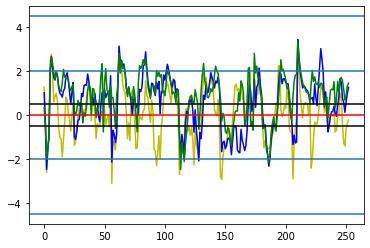

In [25]:
plt.plot(og_zscores, color= 'y')
plt.plot(simple_zscores, color= 'b')
plt.plot(ratio_zscores, color= 'g')

plt.axhline(y=entry)
plt.axhline(y=-entry)
plt.axhline(y=0, color='r')
plt.axhline(y=zstop)
plt.axhline(y=-zstop)
plt.axhline(y=exit, color='k')
plt.axhline(y=-exit, color='k')

In [26]:
from pandas import DataFrame as df

# hedge_lookback = 15

def get_moving_ratios(series1, series2, length):
    zscores = []
    first_set = len(series1)-length-hedge_lookback
    spreads = np.array(series1[first_set:first_set+hedge_lookback])/np.array(series2[first_set:first_set+hedge_lookback])

    for i in range(length):
        start_index = len(series1) - length + i
        spread = series1[start_index]/series2[start_index]
        spreads = np.append(spreads,spread)
        stds = np.std(spreads[-hedge_lookback:])
        spreads_df = df(spreads[-hedge_lookback:])
        spreads_ewm_df = df.ewm(spreads_df, span=hedge_lookback).mean()
        spreads_mean = list(spreads_ewm_df[0])[-1]
        zscores = np.append(zscores,(spread-spreads_mean)/stds)
        
    return spreads[-length:], zscores

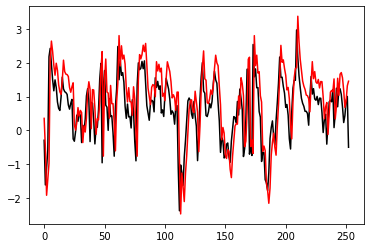

In [27]:
ema_spreads, ema_zscores = get_moving_ratios(series1,series2,dist)
plt.plot(ema_zscores, color='k')
plt.plot(ratio_zscores, color='r')